# Display rasters 

In [2]:
import folium
import os
import numpy as np
import rasterio
import tempfile

from matplotlib import pyplot as plt
from PIL import Image
from rasterio.plot import reshape_as_image
from rasterio.enums import Resampling


In [3]:
!ls ../output/mca_20250419_1305/

prepared_segments.gpkg
segment_popularity_athletes_per_age.tif
segment_popularity_efforts_per_age.tif
segment_popularity_stars_per_age.tif
segment_popularity_stars_per_athlete.tif


'mca_20250419_1305'

In [68]:
output_dir = os.path.join("..", "output")
run_id = next(reversed(sorted(os.listdir(os.path.join("..", "output")))))
raster_files = [f for f in os.listdir(os.path.join(output_dir, run_id)) if f.endswith('.tif')]
raster_files_iter = iter(raster_files)

We've created an iterator, so that the bottom few cells can be reran quickly to show all the rasters present. 

## Iterate through rasters 

In [75]:
raster_file = next(raster_files_iter)
raster_path = os.path.join(output_dir, run_id, raster_file)

print("Raster file:", raster_path)
if not os.path.exists(raster_path):
    raise FileNotFoundError(f"Raster file {raster_path} does not exist.")

with rasterio.open(raster_path) as src:
    src_crs = rasterio.crs.CRS.from_epsg(32633) # to be used in projection later
    print("CRS:", src_crs)
    
    print("Bounds:", src.bounds)
    print("Width x Height:", src.width, "x", src.height)
    print("Number of Bands:", src.count)
    
    raster_data = src.read(
        out_shape=(src.count, 512, 512),  # Downsample if needed
        resampling=Resampling.bilinear
    )
    raster_meta = src.meta
    raster_bounds = src.bounds
    raster_transform = src.transform

Raster file: ../output/mca_20250419_1337/segment_popularity_efforts_per_age.tif
CRS: EPSG:32633
Bounds: BoundingBox(left=244948.59540795124, bottom=6627036.930954419, right=286198.5954079513, top=6661736.930954419)
Width x Height: 1650 x 1388
Number of Bands: 1


In [76]:
# only needed if multiband
if raster_data.shape[0] >= 3:
    image = reshape_as_image(raster_data[:3, :, :])
else:
    image = raster_data[0, :, :]  # Single-band

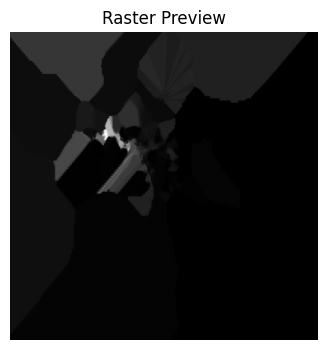

In [77]:
plt.figure(figsize=(4,4))
if image.ndim == 3:
    plt.imshow(image)
else:
    plt.imshow(image, cmap="gray")
plt.title("Raster Preview")
plt.axis("off")
plt.show()

In [78]:
# Normalize image for display
def normalize(arr):
    arr_min, arr_max = np.percentile(arr, (2, 98))
    return np.clip((arr - arr_min) / (arr_max - arr_min), 0, 1)

if image.ndim == 3:
    img_norm = normalize(image.astype(float) / 255)
else:
    img_norm = normalize(image)

img_uint8 = (img_norm * 255).astype(np.uint8)

# needed to display in folium
tmp_img_file = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
if img_uint8.ndim == 2:
    img_uint8 = np.stack([img_uint8]*3, axis=-1)  # convert grayscale to RGB

Image.fromarray(img_uint8).save(tmp_img_file.name)

In [79]:
# Extract bounds in lat/lon (assuming CRS is already in EPSG:4326)
if raster_meta['crs'] != 'EPSG:4326':
    from rasterio.warp import transform_bounds
    # bounds_latlon = transform_bounds(raster_meta['crs'], 'EPSG:4326', *raster_bounds)
    bounds_latlon = transform_bounds(src_crs, 'EPSG:4326', *raster_bounds)
else:
    bounds_latlon = raster_bounds

bounds_latlon

(10.42306602303807, 59.70282362501691, 11.19691085950143, 60.036968976816816)

Raster file: ../output/mca_20250419_1337/segment_popularity_efforts_per_age.tif



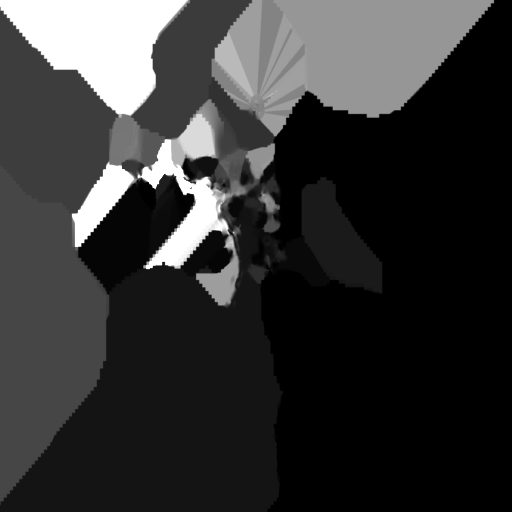

In [81]:
west, south, east, north = bounds_latlon

print("Raster file:", raster_path)

m = folium.Map(location=[(south+north)/2, (west+east)/2], zoom_start=10)
folium.raster_layers.ImageOverlay(
    name="Raster Overlay",
    image=tmp_img_file.name,
    bounds=[[south, west], [north, east]],
    opacity=0.75,
    interactive=True,
    cross_origin=False,
    zindex=1,
).add_to(m)

folium.LayerControl().add_to(m)
m